In [18]:
import os
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import Accuracy, Precision, Recall, F1Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from livelossplot.inputs.keras import PlotLossesCallback

In [19]:
# paths 

data_path = "/home/devesh/Citadel/Assignments/Hewells/split_dataset_3"

In [20]:
# Constants

img_height = 224
img_width = 224

num_classes = 3
batch_size = 32

num_epochs = 100

## Data Preparation

In [21]:
# Assuming you have your images organized in separate folders for each class


datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to 0-1
    rotation_range=40,  # Rotate images randomly by up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Shear images randomly
    zoom_range=0.2,  # Zoom images randomly
    horizontal_flip=True,  # Flip images horizontally randomly
    fill_mode='nearest')  # Fill empty pixels with nearest neighbor interpolation


In [22]:
train_generator = datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')


Found 1449 images belonging to 3 classes.


In [23]:
test_generator = datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 183 images belonging to 3 classes.


In [24]:
val_generator = datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 181 images belonging to 3 classes.


In [25]:
label_map = (test_generator.class_indices)
class_map = dict((v,k) for k, v in label_map.items())

In [26]:
label_map

{'human': 0, 'no_human': 1, 'uber_eats': 2}

In [27]:
n_steps = train_generator.samples // batch_size
n_val_steps = val_generator.samples // batch_size
n_epochs = 100

print(n_steps)

45


## CNN Model

In [28]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))  # Output layer with number of classes

In [29]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [30]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [31]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


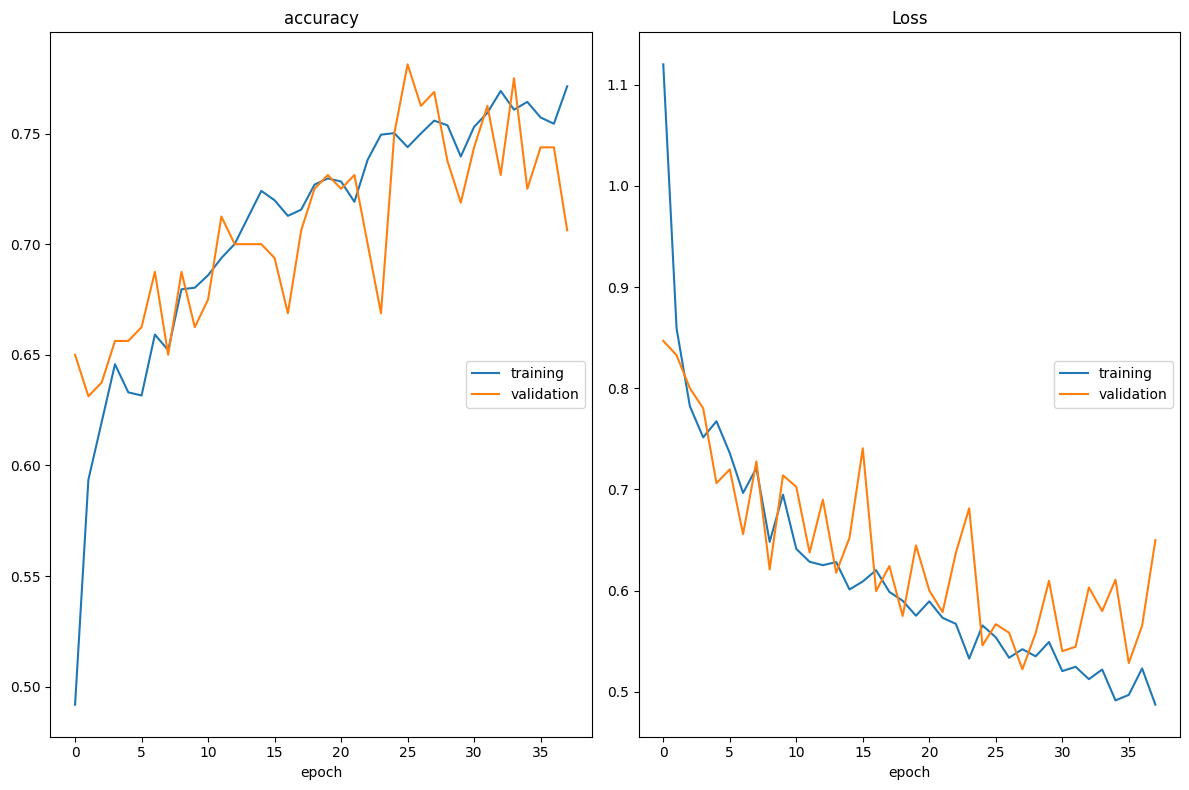

accuracy
	training         	 (min:    0.492, max:    0.771, cur:    0.771)
	validation       	 (min:    0.631, max:    0.781, cur:    0.706)
Loss
	training         	 (min:    0.487, max:    1.120, cur:    0.487)
	validation       	 (min:    0.522, max:    0.847, cur:    0.650)
45/45 [==============================] - 53s 1s/step - loss: 0.4872 - accuracy: 0.7713 - val_loss: 0.6499 - val_accuracy: 0.7063


In [32]:
history = model.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=val_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from keras.models import load_model

In [35]:
def get_report():
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    report1 = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    report2 = classification_report(true_classes, predicted_classes, target_names=class_labels)

    print(report2)

In [36]:
get_report()

6/6 [==============================] - 4s 726ms/step
              precision    recall  f1-score   support

       human       0.30      0.39      0.34        62
    no_human       0.12      0.04      0.06        47
   uber_eats       0.35      0.41      0.38        74

    accuracy                           0.31       183
   macro avg       0.26      0.28      0.26       183
weighted avg       0.27      0.31      0.28       183



In [36]:
def predict_class(image_path):
    # Load the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)

    # Preprocess the image
    img_batch = np.expand_dims(img_array, axis=0)
    img_batch = img_batch / 255.0  # Normalize to [0, 1] range

    # Make predictions
    predictions = model.predict(img_batch)[0]
    
    pred_class = predictions.argmax()
    pred_prob = predictions[pred_class]

    pred_label = class_map[pred_class]

    return pred_label, pred_prob


In [39]:
test_path = "/Users/deveshparmar/Citadel/Assignments/Hawells/images_dataset/test"
image_path = os.path.join(test_path, "zomato", "30.png")
predict_class(image_path)


1/1 [==============================] - 0s 32ms/step


('zomato', 0.7918542)

In [41]:
test_path = "/Users/deveshparmar/Citadel/Assignments/Hawells/images_dataset/test"
image_path = os.path.join(test_path, "no_human", "192.png")
predict_class(image_path)

1/1 [==============================] - 0s 31ms/step


('human', 0.5685417)

In [42]:
test_path = "/Users/deveshparmar/Citadel/Assignments/Hawells/images_dataset/test"
image_path = os.path.join(test_path, "human", "181.png")
predict_class(image_path)

1/1 [==============================] - 0s 29ms/step


('human', 0.6116264)

In [48]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

4/4 [==============================] - 3s 594ms/step


In [ ]:
labeldic = {}
for key,value in  test_generator.class_indices.items():
    labeldic[value] = key
print(labeldic)